# CATBOOST best model
The purpose of this notebook is to perform the explainability part of our CatBoost model. Fortunately Catboost has the TreeShap functionality already implemented.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor
import shap
import sys

In [26]:
data = pd.read_csv('../Data/TFM_Hdataset_Gtrends.csv', index_col=0)
data

,Description,Seasonality,Year,Week,Channel,WSSI Category,LIMITED EDITION STYLES,Originals,Source,sales,...,Price,Discount,Margin,RRP,Markdown,Cost,month,Channel2,CategoryCluster,ProductCluster
0,Astrid,OLD,2017,1,DE Direct,Womens Active Shoes,0.0,0.0,NONE,1.0,...,38.526679,0.000000,25.758448,50.378410,11.851731,12.768232,1,US,Cluster 6,Cluster 2
1,Charmaine,SS,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,58.225767,0.000000,44.100962,58.395499,0.169733,14.124805,1,US,Cluster 0,Cluster 2
2,Chile,SS,2017,1,DE Direct,Womens Casual Shoes,0.0,0.0,NONE,1.0,...,58.225767,0.000000,46.649675,58.395499,0.169733,11.576091,1,US,Cluster 3,Cluster 7
3,Devotion,AW,2017,1,DE Direct,Womens Slippers,0.0,0.0,NONE,2.0,...,26.457288,0.000000,17.882101,34.688819,8.231530,8.575187,1,US,Cluster 0,Cluster 2
4,Donna,CONT,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,69.982735,0.000000,54.114939,70.192570,0.209836,15.867796,1,US,Cluster 0,Cluster 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324424,Waltham,AW,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,20.0,...,52.500000,0.000000,29.532000,87.500000,35.000000,22.968000,12,UK,Cluster 4,Cluster 6
324425,Whisper,AW,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,74.0,...,45.586351,0.000000,25.807703,70.833333,25.246982,19.778649,12,UK,Cluster 4,Cluster 4
324426,Whisper,CONT,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,83.0,...,54.996024,0.046867,35.907952,70.833333,15.790441,19.088072,12,UK,Cluster 4,Cluster 4
324427,Wrap,AW,2021,50,Wholesale,Womens Slippers,0.0,0.0,MANUFACTURED,28.0,...,29.170000,0.000000,14.480000,49.166666,19.996666,14.690000,12,UK,Cluster 0,Cluster 2


In [27]:
data['Date'] = pd.to_datetime(data['Date'])

conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']== 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)

In [28]:
data = data[['Description', 'Seasonality', 'Year', 'Week_sin','Week_cos', 'Channel',
       'WSSI Category','Originals', 'Source',
       'gender', 'style', 'prev_sales2', 'prev_sales3',
       'prev_sales4', 'Price', 'Discount', 'prev_mean_price',
       'RRP', 'Markdown', 'Cost', 'CategoryCluster','Date',
       'ProductCluster','sales']]

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
# Helper function to plot shap values
def shap_plot(j,mod_cb,X_test):
    explainerModel = shap.TreeExplainer(mod_cb)
    shap_values_Model = explainerModel.shap_values(X_test)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test[j])
    return(p)

def catb(data_s):
    
    categorical_features_indices = np.where(data_s.dtypes != np.float64)[0]
    print(categorical_features_indices)
    
    X = data_s[(data_d['Date']<'01-01-2019')].values
    T = data_s[(data_d['Date']>='01-01-2019')&(data_d['Date']<'01-01-2020')].values  
    data_i = data_s.drop(['sales'], axis=1)

    X_train,y_train = X[:,:-1], X[:,-1]
    X_test,y_test = T[:,:-1], T[:,-1] 
    
    train_pool = catboost.Pool(X_train, y_train, cat_features=categorical_features_indices)
    valid_pool = catboost.Pool(X_test, y_test, cat_features=categorical_features_indices)

    mod_cb = CatBoostRegressor(iterations=60, depth=11, learning_rate=0.1, od_type= "Iter", loss_function='RMSE')
    mod_cb = mod_cb.fit(train_pool,eval_set=valid_pool,plot=True)
    y_hat = mod_cb.predict(X_test)
    y_hat_m = mod_cb.predict(X_train)
    
    score = r2_score(y_test,y_hat)
    score2 = mean_squared_error(y_test,y_hat)
    score3 = mean_absolute_error(y_test,y_hat)
    
    score_m = r2_score(y_train,y_hat_m)
    score2_m = mean_squared_error(y_train,y_hat_m)
    score3_m = mean_absolute_error(y_train,y_hat_m)
    
    feat = pd.DataFrame({'feature_importance': mod_cb.get_feature_importance(
                                                                               train_pool,
                                                                               type=catboost.EFstrType.FeatureImportance,
                                                                               prettified=False,
                                                                               thread_count=-1,
                                                                               verbose=False,
                                                                               log_cout=sys.stdout,
                                                                               log_cerr=sys.stderr), 
                        'feature_names': data_i.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
    
    shap_values = mod_cb.get_feature_importance(
                                               train_pool,
                                               type=catboost.EFstrType.ShapValues)
                        
    
    print(feat)
    shap.summary_plot(shap_values[:, :-1], X_train, feature_names=data_i.columns.tolist(), plot_type="bar")
    shap.summary_plot(shap_values[:, :-1], X_train, feature_names=data_i.columns.tolist())
    #print(shap_plot(0,mod_cb,X_test))
    #print(shap_plot(10,mod_cb,X_test))
    
    interactions = mod_cb.get_feature_importance(train_pool, fstr_type=catboost.EFstrType.Interaction)
    feature_interaction = [[data_i.columns[interaction[0]], data_i.columns[interaction[1]], interaction[2]] for interaction in interactions]
    feature_interaction_df = pd.DataFrame(feature_interaction, columns=['feature1', 'feature2', 'interaction_strength'])
    print(feature_interaction_df.head(10))


    return y_hat, score, score2, score3, y_hat_m, score_m, score2_m, score3_m



Cluster 6
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 94.1966408	test: 76.2486497	best: 76.2486497 (0)	total: 54.5ms	remaining: 3.21s
1:	learn: 90.2202796	test: 73.2523166	best: 73.2523166 (1)	total: 117ms	remaining: 3.38s
2:	learn: 86.5790290	test: 70.3035366	best: 70.3035366 (2)	total: 178ms	remaining: 3.39s
3:	learn: 83.5192341	test: 68.5507583	best: 68.5507583 (3)	total: 241ms	remaining: 3.38s
4:	learn: 80.8960303	test: 66.5051510	best: 66.5051510 (4)	total: 311ms	remaining: 3.42s
5:	learn: 78.4351885	test: 64.9602087	best: 64.9602087 (5)	total: 373ms	remaining: 3.36s
6:	learn: 75.9877431	test: 63.5640902	best: 63.5640902 (6)	total: 430ms	remaining: 3.25s
7:	learn: 74.0912055	test: 62.2190092	best: 62.2190092 (7)	total: 483ms	remaining: 3.14s
8:	learn: 72.3444737	test: 61.2584411	best: 61.2584411 (8)	total: 544ms	remaining: 3.08s
9:	learn: 70.6038923	test: 60.4044017	best: 60.4044017 (9)	total: 606ms	remaining: 3.03s
10:	learn: 69.0984136	test: 59.5744268	best: 59.5744268 (10)	total: 665ms	remaining: 2.96s
11:	learn: 67.3987

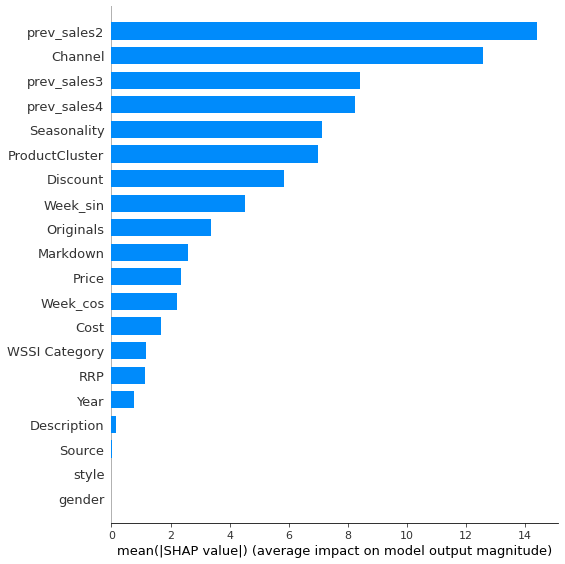

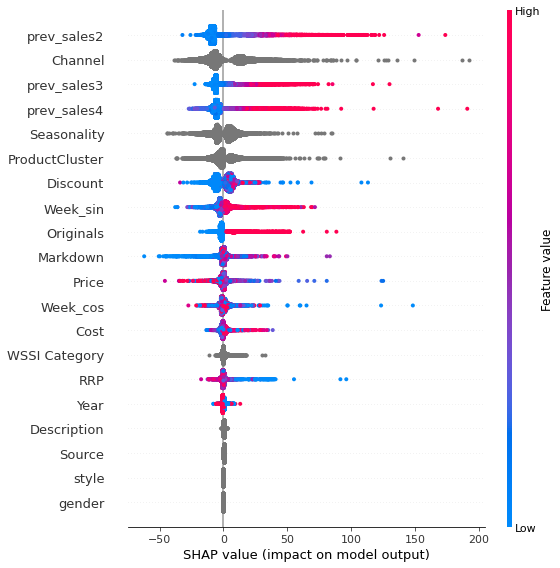

      feature1        feature2  interaction_strength
0  prev_sales2     prev_sales3              4.029939
1      Channel        Markdown              2.841115
2  Seasonality         Channel              2.633411
3      Channel  ProductCluster              2.511249
4      Channel           Price              2.426487
5  prev_sales2        Markdown              2.260218
6  prev_sales4           Price              2.008340
7  prev_sales3        Markdown              2.003024
8        Price        Discount              1.945729
9  prev_sales4        Markdown              1.804258
Error Plots
Price vs error


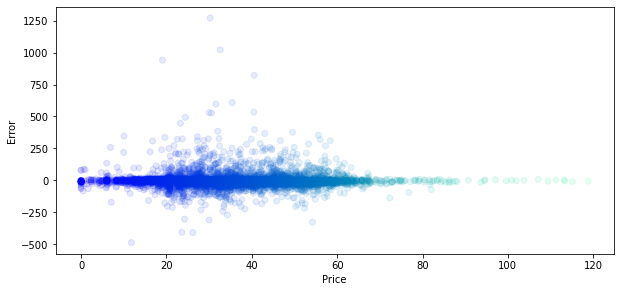

Sales vs error


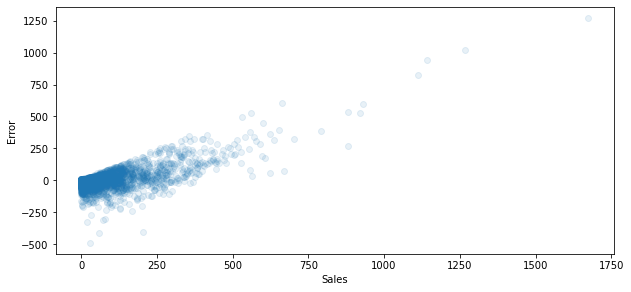

Cluster 0
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 74.6616435	test: 53.1004951	best: 53.1004951 (0)	total: 77.3ms	remaining: 4.56s
1:	learn: 71.6559304	test: 51.1608853	best: 51.1608853 (1)	total: 155ms	remaining: 4.49s
2:	learn: 68.8500201	test: 49.7670559	best: 49.7670559 (2)	total: 234ms	remaining: 4.45s
3:	learn: 66.2252448	test: 48.7626576	best: 48.7626576 (3)	total: 313ms	remaining: 4.39s
4:	learn: 64.1581216	test: 47.5925863	best: 47.5925863 (4)	total: 389ms	remaining: 4.28s
5:	learn: 62.0719769	test: 46.6846696	best: 46.6846696 (5)	total: 462ms	remaining: 4.15s
6:	learn: 60.3680090	test: 45.8939307	best: 45.8939307 (6)	total: 541ms	remaining: 4.09s
7:	learn: 58.5884451	test: 45.0691412	best: 45.0691412 (7)	total: 619ms	remaining: 4.02s
8:	learn: 57.1000198	test: 44.4793016	best: 44.4793016 (8)	total: 695ms	remaining: 3.94s
9:	learn: 55.8236070	test: 43.8947017	best: 43.8947017 (9)	total: 776ms	remaining: 3.88s
10:	learn: 54.6672710	test: 43.4365357	best: 43.4365357 (10)	total: 849ms	remaining: 3.78s
11:	learn: 53.7316

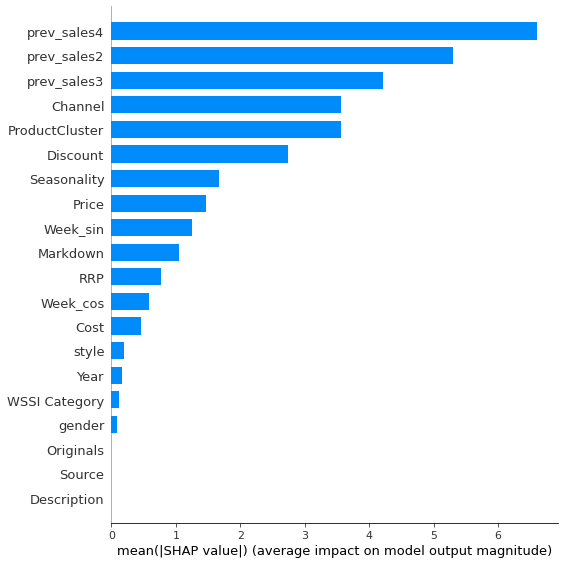

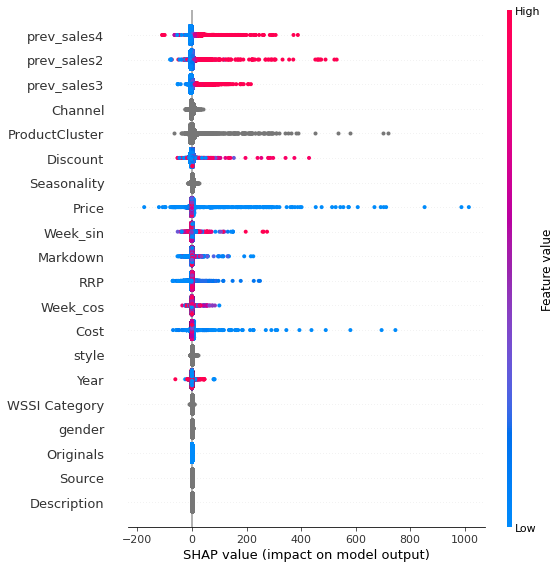

      feature1        feature2  interaction_strength
0  prev_sales2           Price              6.609174
1        Price  ProductCluster              5.943834
2  prev_sales2     prev_sales4              4.247279
3  prev_sales4           Price              4.157602
4        Price        Discount              3.501811
5        Price            Cost              3.500157
6  prev_sales2  ProductCluster              3.059588
7     Week_sin           Price              2.711374
8  prev_sales2     prev_sales3              2.679977
9  prev_sales3           Price              2.660856
Error Plots
Price vs error


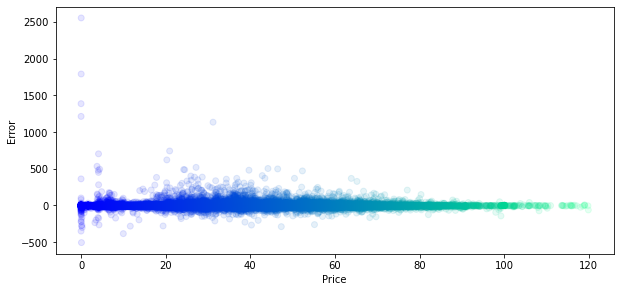

Sales vs error


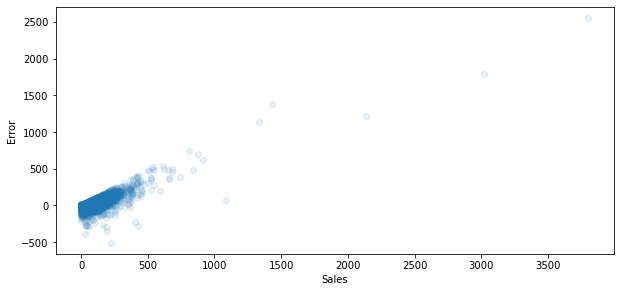

Cluster 3
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 114.2454685	test: 87.5342700	best: 87.5342700 (0)	total: 61.4ms	remaining: 3.63s
1:	learn: 108.8569059	test: 82.0917697	best: 82.0917697 (1)	total: 120ms	remaining: 3.47s
2:	learn: 104.1316421	test: 77.4341410	best: 77.4341410 (2)	total: 180ms	remaining: 3.42s
3:	learn: 99.7711980	test: 72.9430189	best: 72.9430189 (3)	total: 242ms	remaining: 3.38s
4:	learn: 96.1592539	test: 69.9908712	best: 69.9908712 (4)	total: 304ms	remaining: 3.35s
5:	learn: 92.5411329	test: 66.3585259	best: 66.3585259 (5)	total: 368ms	remaining: 3.31s
6:	learn: 89.2205740	test: 63.4757934	best: 63.4757934 (6)	total: 431ms	remaining: 3.26s
7:	learn: 86.3041678	test: 60.8546178	best: 60.8546178 (7)	total: 492ms	remaining: 3.2s
8:	learn: 83.7285121	test: 58.8369040	best: 58.8369040 (8)	total: 556ms	remaining: 3.15s
9:	learn: 81.4414289	test: 56.8717319	best: 56.8717319 (9)	total: 615ms	remaining: 3.07s
10:	learn: 79.1574798	test: 55.1454441	best: 55.1454441 (10)	total: 677ms	remaining: 3.02s
11:	learn: 77.38

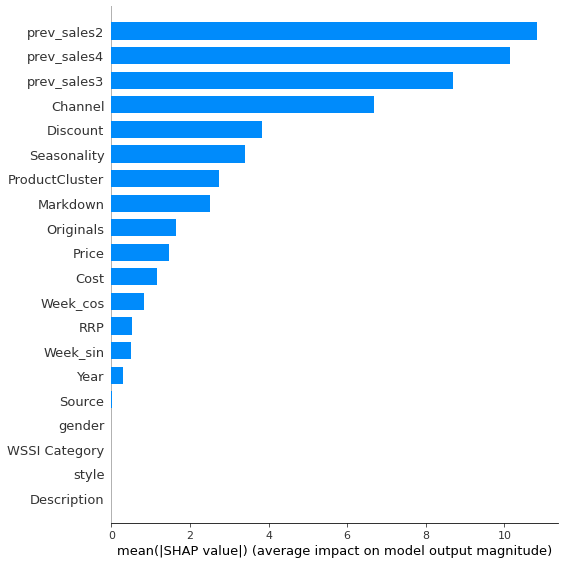

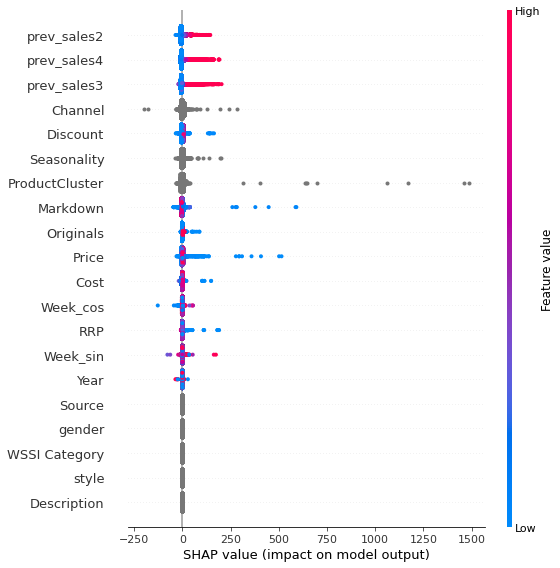

      feature1        feature2  interaction_strength
0  prev_sales3  ProductCluster              5.609395
1     Markdown  ProductCluster              4.827305
2  prev_sales2  ProductCluster              4.361837
3  prev_sales4  ProductCluster              4.178776
4      Channel  ProductCluster              3.695748
5  Seasonality  ProductCluster              3.537970
6  prev_sales2     prev_sales3              3.378152
7  prev_sales2     prev_sales4              2.870575
8        Price  ProductCluster              2.794042
9  prev_sales3     prev_sales4              2.593002
Error Plots
Price vs error


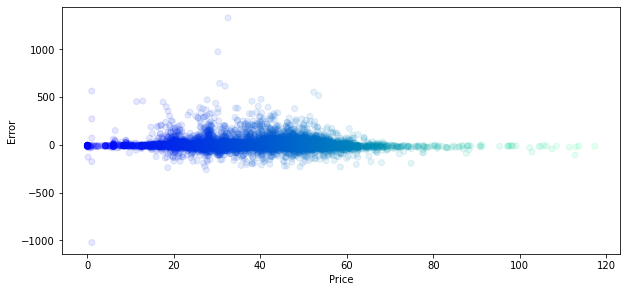

Sales vs error


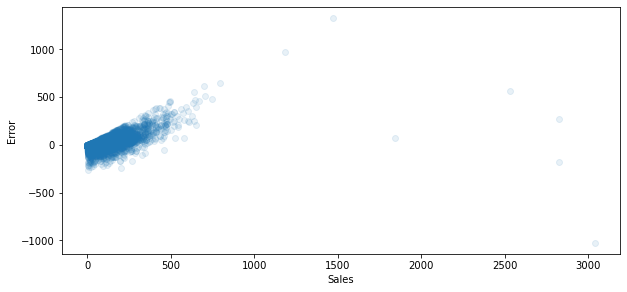

Cluster 2
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 143.9253907	test: 146.7909588	best: 146.7909588 (0)	total: 46.6ms	remaining: 2.75s
1:	learn: 135.4598692	test: 138.9555620	best: 138.9555620 (1)	total: 92.8ms	remaining: 2.69s
2:	learn: 128.1003470	test: 133.4619342	best: 133.4619342 (2)	total: 143ms	remaining: 2.72s
3:	learn: 121.4652972	test: 130.0199498	best: 130.0199498 (3)	total: 204ms	remaining: 2.85s
4:	learn: 115.5323914	test: 124.9134777	best: 124.9134777 (4)	total: 258ms	remaining: 2.83s
5:	learn: 109.9816152	test: 120.4148340	best: 120.4148340 (5)	total: 322ms	remaining: 2.9s
6:	learn: 105.3757613	test: 117.0234350	best: 117.0234350 (6)	total: 374ms	remaining: 2.83s
7:	learn: 101.1609962	test: 113.2186711	best: 113.2186711 (7)	total: 399ms	remaining: 2.59s
8:	learn: 97.4053729	test: 111.2987654	best: 111.2987654 (8)	total: 454ms	remaining: 2.58s
9:	learn: 93.8385389	test: 108.0683616	best: 108.0683616 (9)	total: 506ms	remaining: 2.53s
10:	learn: 90.8219195	test: 106.1167525	best: 106.1167525 (10)	total: 553ms	remai

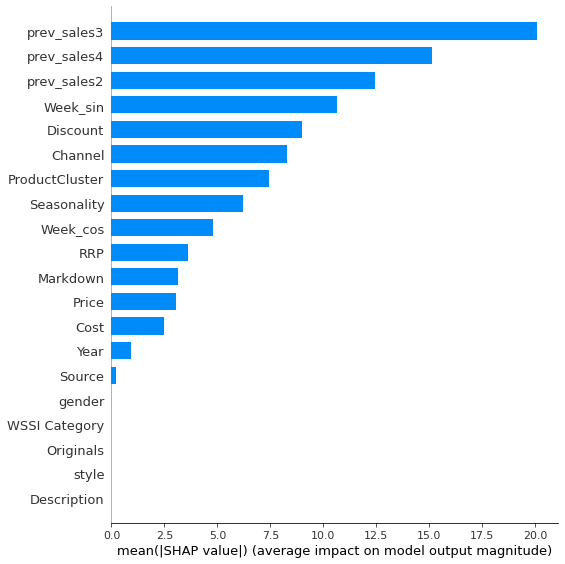

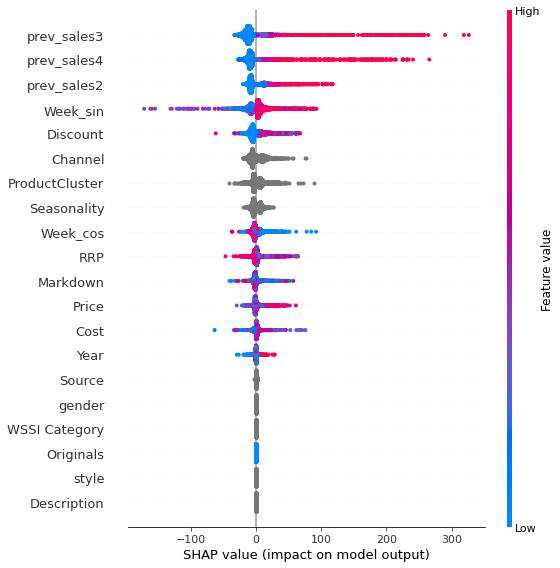

      feature1     feature2  interaction_strength
0  prev_sales3     Markdown              3.369586
1  prev_sales2  prev_sales4              3.227479
2     Week_sin  prev_sales3              3.133434
3     Week_cos  prev_sales3              2.988373
4  prev_sales3  prev_sales4              2.923649
5     Week_sin  prev_sales4              2.888896
6  prev_sales2  prev_sales3              2.677693
7  prev_sales4          RRP              2.559318
8  prev_sales3         Cost              2.486880
9  prev_sales3     Discount              2.388648
Error Plots
Price vs error


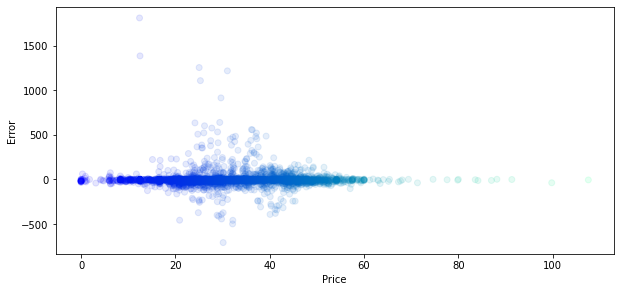

Sales vs error


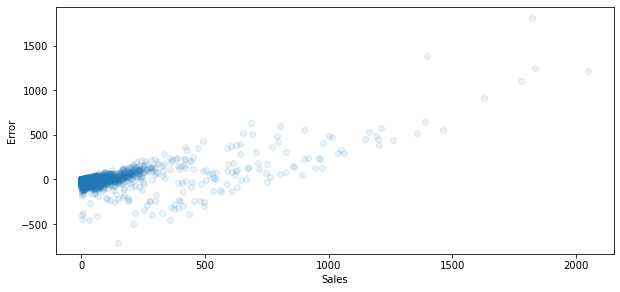

Cluster 5
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 127.5735662	test: 142.5492298	best: 142.5492298 (0)	total: 48.3ms	remaining: 2.85s
1:	learn: 121.2159923	test: 141.1385745	best: 141.1385745 (1)	total: 102ms	remaining: 2.97s
2:	learn: 114.8836132	test: 135.8496767	best: 135.8496767 (2)	total: 165ms	remaining: 3.13s
3:	learn: 109.1565763	test: 130.8521791	best: 130.8521791 (3)	total: 229ms	remaining: 3.21s
4:	learn: 104.1117695	test: 126.1028883	best: 126.1028883 (4)	total: 295ms	remaining: 3.25s
5:	learn: 99.6122299	test: 125.1525735	best: 125.1525735 (5)	total: 357ms	remaining: 3.21s
6:	learn: 95.8155178	test: 121.7800148	best: 121.7800148 (6)	total: 422ms	remaining: 3.19s
7:	learn: 92.4951799	test: 119.4652730	best: 119.4652730 (7)	total: 488ms	remaining: 3.17s
8:	learn: 89.4131272	test: 117.2587494	best: 117.2587494 (8)	total: 556ms	remaining: 3.15s
9:	learn: 86.6629668	test: 114.2540555	best: 114.2540555 (9)	total: 620ms	remaining: 3.1s
10:	learn: 84.3309264	test: 112.2515758	best: 112.2515758 (10)	total: 689ms	remaining

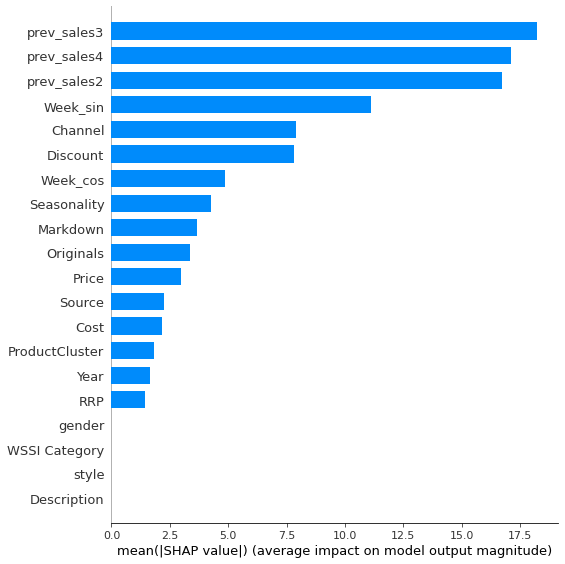

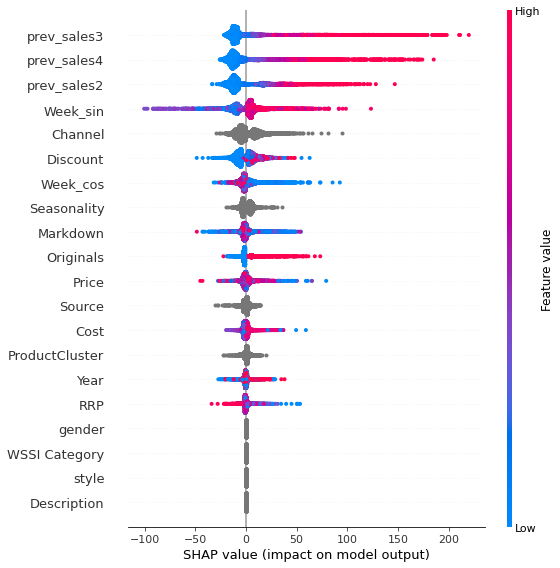

      feature1     feature2  interaction_strength
0     Week_sin  prev_sales4              4.918466
1     Week_sin  prev_sales3              3.623405
2  prev_sales2     Markdown              3.522271
3  prev_sales3  prev_sales4              3.162822
4  prev_sales2  prev_sales4              3.110993
5     Week_sin  prev_sales2              2.800506
6  prev_sales2  prev_sales3              2.749733
7  prev_sales4     Markdown              2.171632
8     Week_sin     Markdown              1.990633
9        Price     Discount              1.927690
Error Plots
Price vs error


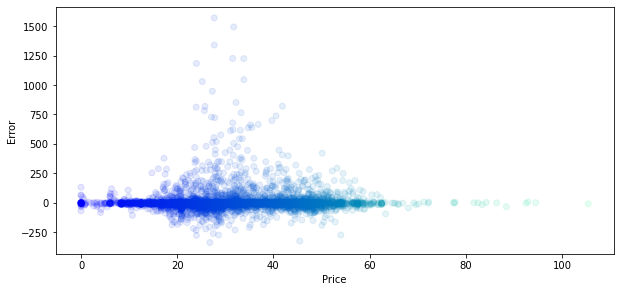

Sales vs error


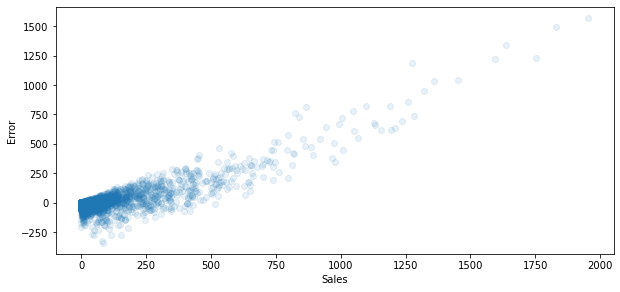

Cluster 4
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 178.1997413	test: 133.1978607	best: 133.1978607 (0)	total: 66.6ms	remaining: 3.93s
1:	learn: 168.1205304	test: 125.6963320	best: 125.6963320 (1)	total: 131ms	remaining: 3.79s
2:	learn: 157.9216009	test: 117.8712582	best: 117.8712582 (2)	total: 193ms	remaining: 3.67s
3:	learn: 149.3735145	test: 111.8927503	best: 111.8927503 (3)	total: 260ms	remaining: 3.65s
4:	learn: 141.0557146	test: 106.5309360	best: 106.5309360 (4)	total: 325ms	remaining: 3.57s
5:	learn: 133.6414179	test: 101.6827328	best: 101.6827328 (5)	total: 397ms	remaining: 3.57s
6:	learn: 127.5571593	test: 98.0118109	best: 98.0118109 (6)	total: 472ms	remaining: 3.57s
7:	learn: 121.9373493	test: 94.6150819	best: 94.6150819 (7)	total: 543ms	remaining: 3.53s
8:	learn: 116.5796041	test: 90.7984320	best: 90.7984320 (8)	total: 609ms	remaining: 3.45s
9:	learn: 111.8814272	test: 88.4507157	best: 88.4507157 (9)	total: 684ms	remaining: 3.42s
10:	learn: 107.7573084	test: 86.1912905	best: 86.1912905 (10)	total: 723ms	remaining: 3

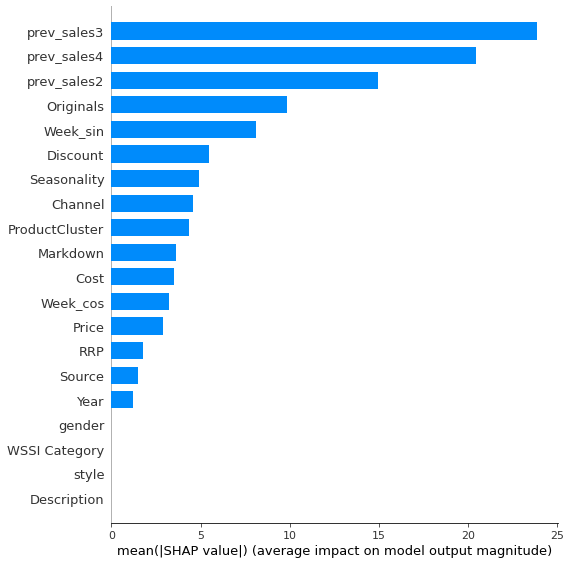

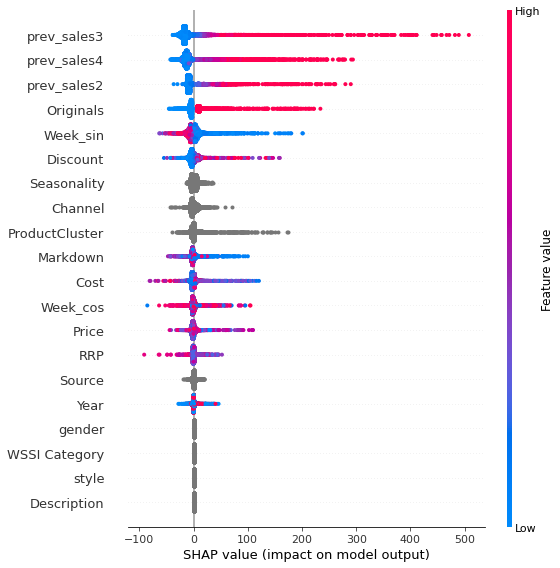

      feature1     feature2  interaction_strength
0  prev_sales2  prev_sales3              5.284936
1  prev_sales3  prev_sales4              4.114431
2     Week_sin  prev_sales3              3.562634
3     Week_sin  prev_sales4              3.301742
4  prev_sales3         Cost              3.138633
5    Originals  prev_sales3              2.787795
6  prev_sales3        Price              2.606512
7  prev_sales3     Markdown              2.278766
8    Originals  prev_sales4              2.129419
9  prev_sales2  prev_sales4              1.973967
Error Plots
Price vs error


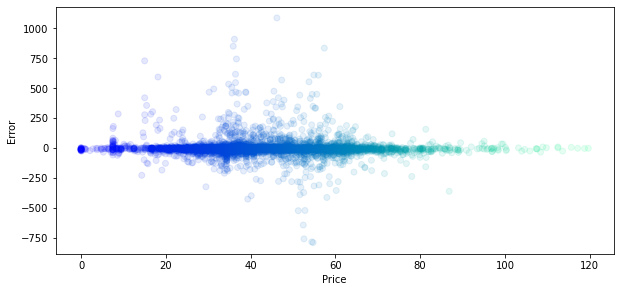

Sales vs error


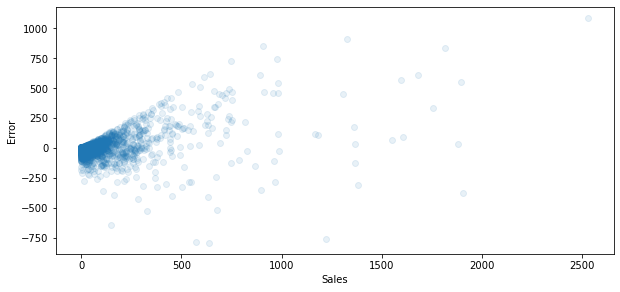

Cluster 1
[ 0  1  2  5  6  8  9 10 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 218.4967398	test: 217.7887779	best: 217.7887779 (0)	total: 49.4ms	remaining: 2.91s
1:	learn: 201.9646958	test: 200.9828838	best: 200.9828838 (1)	total: 99.4ms	remaining: 2.88s
2:	learn: 186.1551197	test: 185.0864378	best: 185.0864378 (2)	total: 151ms	remaining: 2.87s
3:	learn: 172.2210676	test: 170.1707233	best: 170.1707233 (3)	total: 207ms	remaining: 2.9s
4:	learn: 159.9225454	test: 157.4176661	best: 157.4176661 (4)	total: 260ms	remaining: 2.86s
5:	learn: 149.4165222	test: 149.6595582	best: 149.6595582 (5)	total: 328ms	remaining: 2.96s
6:	learn: 140.3436534	test: 140.9244447	best: 140.9244447 (6)	total: 382ms	remaining: 2.89s
7:	learn: 131.0498755	test: 130.2213304	best: 130.2213304 (7)	total: 433ms	remaining: 2.82s
8:	learn: 122.8429922	test: 121.8345577	best: 121.8345577 (8)	total: 484ms	remaining: 2.74s
9:	learn: 115.9287767	test: 113.8318930	best: 113.8318930 (9)	total: 537ms	remaining: 2.69s
10:	learn: 109.7500321	test: 108.2922679	best: 108.2922679 (10)	total: 591ms	re

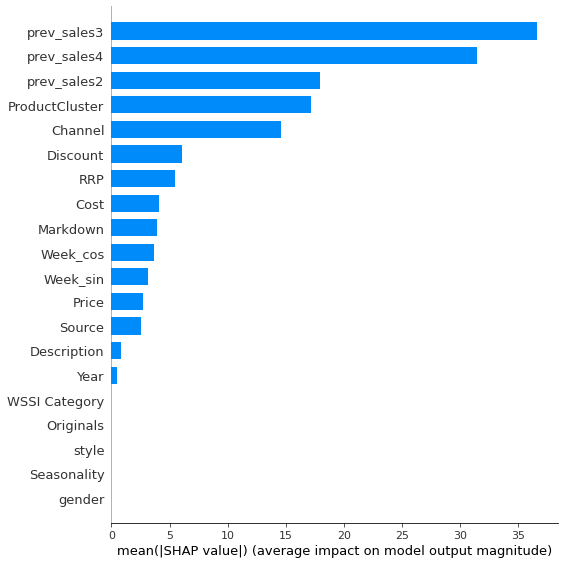

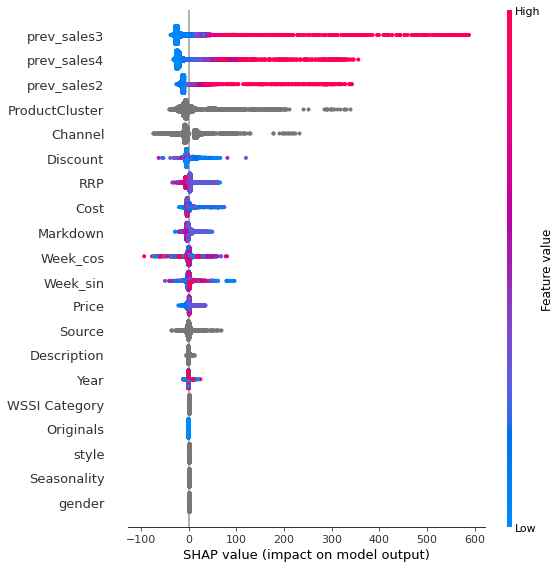

      feature1        feature2  interaction_strength
0  prev_sales3     prev_sales4              8.975952
1  prev_sales2     prev_sales3              7.249107
2      Channel  ProductCluster              3.659189
3  prev_sales2     prev_sales4              3.569440
4  prev_sales4            Cost              3.404357
5     Week_sin     prev_sales3              2.941449
6     Week_cos     prev_sales3              2.866654
7     Week_cos     prev_sales2              2.848982
8     Week_sin     prev_sales4              2.742708
9  prev_sales4        Discount              2.511537
Error Plots
Price vs error


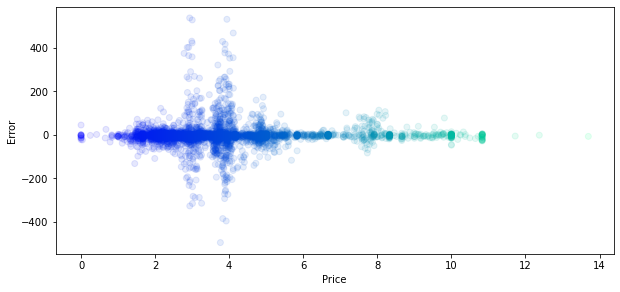

Sales vs error


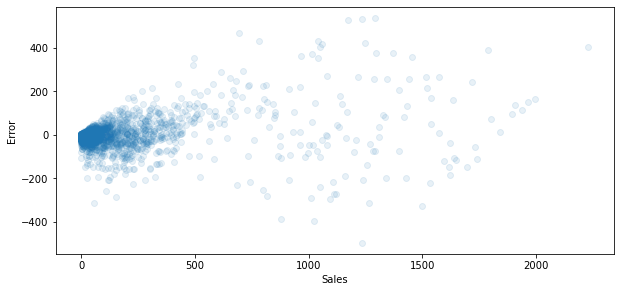

[0.58281362 0.54124184 0.71845175 0.66439607 0.60841071 0.73658403
 0.9462619 ]


In [33]:
scores = np.zeros((7))
scores2 = np.zeros((7))
scores3 = np.zeros((7))
scores_m = np.zeros((7))
scores2_m = np.zeros((7))
scores3_m = np.zeros((7))
errors = 0
j = 0

for category in data['CategoryCluster'].unique():
    data_d = data.loc[data['CategoryCluster']==category]    
    data_c = data_d.drop(['CategoryCluster','Date','prev_mean_price'], axis=1)
    
    print(category)
    y_hat, score, score2, score3, y_hat_m, score_m, score2_m, score3_m = catb(data_c)
    
    scores[j] = np.mean(score)
    scores2[j] = np.mean(score2)
    scores3[j] = np.mean(score3)
    scores_m[j] = np.mean(score_m)
    scores2_m[j] = np.mean(score2_m)
    scores3_m[j] = np.mean(score3_m)
    
    data_validation = data_d[(data_d['Date']>='01-01-2019')&(data_d['Date']<'01-01-2020')]
    data_validation['y_hat'] = y_hat
    data_validation['error'] = data_validation['sales'] - data_validation['y_hat']   
    
    data_validation_m = data_d[(data_d['Date']<'01-01-2019')]
    data_validation_m['y_hat_m'] = y_hat_m
    data_validation_m['error_m'] = data_validation_m['sales'] - data_validation_m['y_hat_m']
    
    if j==0:
        df = data_validation
        df['CategoryCluster'] = category
        df_m = data_validation_m
        df_m['CategoryCluster'] = category
    else:
        data_validation['CategoryCluster']=category
        data_validation_m['CategoryCluster']=category
        df = pd.concat([df,data_validation])
        df_m = pd.concat([df_m,data_validation_m])
    
    
    x = data_validation['Price']
    x2 = data_validation['sales']
    y = data_validation['error']
    
    print('Error Plots')
    plt.figure(figsize=(10,10))
    print('Price vs error')
    plt.subplot(211)
    plt.scatter(x,y, c=x, cmap='winter', alpha=0.1)
    plt.xlabel('Price')
    plt.ylabel('Error')
    plt.show()
    plt.figure(figsize=(10,10))
    print('Sales vs error')
    plt.subplot(212)
    plt.scatter(x2,y,  cmap='winter', alpha=0.1)
    plt.xlabel('Sales')
    plt.ylabel('Error')
    plt.show()
    
    j += 1
print(scores) 